---
## <center>IMPORT STATEMENTS

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import joblib

---
## <center>DATASET LOADING

In [2]:
csv_files = [f for f in os.listdir("../data/") if f.endswith('.csv')]
csv_files

['NYC_PAR.csv',
 'NYC_RUH.csv',
 'NYC_SVO.csv',
 'PAR_NYC.csv',
 'PAR_RUH.csv',
 'PAR_SVO.csv',
 'RUH_NYC.csv',
 'RUH_PAR.csv',
 'RUH_SVO.csv',
 'SVO_NYC.csv',
 'SVO_PAR.csv',
 'SVO_RUH.csv']

In [3]:
combined_df = pd.concat([pd.read_csv(os.path.join("../data/", file)) for file in csv_files], ignore_index=True)
combined_df.to_csv('../data/refined data/new_dataset.csv', index=False)
print("All datasets combined and saved to 'new_dataset.csv'")

All datasets combined and saved to 'new_dataset.csv'


In [4]:
df=pd.read_csv('../data/refined data/new_dataset.csv')

---
## <CENTER>GAINING INFO

In [5]:
df.head()

,Airline,Source,Destination,Duration,Total stops,Price,Date
0,Air France,NYC,PAR,7h 20m,nonstop,"1,031 SAR",2022-02-01
1,Air France,NYC,PAR,7h 20m,nonstop,"1,031 SAR",2022-02-01
2,Air France,NYC,PAR,7h 20m,nonstop,"1,031 SAR",2022-02-01
3,Air France,NYC,PAR,7h 10m,nonstop,"1,238 SAR",2022-02-01
4,Air France,NYC,PAR,7h 20m,nonstop,"1,238 SAR",2022-02-01


In [6]:
df.columns

Index(['Airline', 'Source', 'Destination', 'Duration', 'Total stops', 'Price',
       'Date'],
      dtype='object')

In [7]:
shape=df.shape
print("No. of rows: ",shape[0],"\nNo. of columns: ",shape[1])

No. of rows:  55363 
No. of columns:  7


In [8]:
df.describe()

,Airline,Source,Destination,Duration,Total stops,Price,Date
count,55363,55363,55363,55363,55363,55363,55363
unique,839,4,4,910,4,4950,166
top,Delta,PAR,NYC,17h 05m,1 stop,"5,751 SAR",2022-04-23
freq,4486,24611,26362,552,28873,721,1174


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55363 entries, 0 to 55362
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Airline      55363 non-null  object
 1   Source       55363 non-null  object
 2   Destination  55363 non-null  object
 3   Duration     55363 non-null  object
 4   Total stops  55363 non-null  object
 5   Price        55363 non-null  object
 6   Date         55363 non-null  object
dtypes: object(7)
memory usage: 3.0+ MB


---
## <CENTER>DATA MANIPULATION

In [10]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='mixed')

In [11]:
print(df['Price'].unique())

['1,031\xa0SAR ' '1,238\xa0SAR ' '1,353\xa0SAR ' ... '2,781\xa0SAR '
 '2,395\xa0SAR ' '4,042\xa0SAR ']


In [12]:
df['Price'] = df['Price'].str.replace(',', '')                 # Remove commas
df['Price'] = df['Price'].str.replace('\xa0', '', regex=False) # Remove non-breaking space
df['Price'] = df['Price'].str.replace('SAR', '').str.strip()   # Remove "SAR" and extra spaces
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')      # Convert to floa

In [13]:
def convert_duration_to_minutes(x):
    x = x.lower().strip()
    hours = minutes = 0
    if 'h' in x:
        hours = int(x.split('h')[0].strip())
        x = x.split('h')[1]
    if 'm' in x:
        minutes = int(x.split('m')[0].strip())
    return hours * 60 + minutes

df['Duration'] = df['Duration'].apply(convert_duration_to_minutes)

In [14]:
df['Total stops'] = df['Total stops'].str.lower().str.replace('nonstop ', '0 stop')
df['Total stops'] = df['Total stops'].str.extract(r'(\d)').astype(float)

In [15]:
df['Airline']=df['Airline'].astype(str)
df['Source']=df['Source'].astype(str)
df['Destination']=df['Destination'].astype(str)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55363 entries, 0 to 55362
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Airline      55363 non-null  object        
 1   Source       55363 non-null  object        
 2   Destination  55363 non-null  object        
 3   Duration     55363 non-null  int64         
 4   Total stops  55363 non-null  float64       
 5   Price        55363 non-null  int64         
 6   Date         55363 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 3.0+ MB


---
## <center>HANDLING MISSING VALUES

In [17]:
df.isna().sum()

Airline        0
Source         0
Destination    0
Duration       0
Total stops    0
Price          0
Date           0
dtype: int64

* #### we don't have any missing values in our dataset

---
## <center>Mean Encode 'Airline' and 'Source'

In [18]:
# Mean encoding
df['Airline_encoded'] = df.groupby('Airline')['Price'].transform('mean')
df['Source_encoded'] = df.groupby('Source')['Price'].transform('mean')

In [19]:
#We’ll create a squared feature for Duration:
df['Duration_squared'] = df['Duration'] ** 2

In [20]:
df.sample(15)

,Airline,Source,Destination,Duration,Total stops,Price,Date,Airline_encoded,Source_encoded,Duration_squared
47209,"Finnair, American Airlines",SVO,NYC,1022,2.0,11636,2022-03-16,11625.680556,4183.056097,1044484
17912,KLM,PAR,NYC,665,1.0,10038,2022-02-25,3433.239810,5482.585632,442225
16601,Air Canada,PAR,NYC,691,1.0,1747,2022-02-22,4031.106770,5482.585632,477481
37199,Emirates,RUH,NYC,1080,1.0,2993,2022-02-19,3474.625511,4056.772000,1166400
45123,"Royal Jordanian, Air Serbia",RUH,SVO,855,3.0,2354,2022-04-06,2354.000000,4056.772000,731025
25201,American Airlines,PAR,NYC,725,1.0,10000,2022-04-30,7810.620635,5482.585632,525625
5691,SAUDIA,NYC,RUH,1300,1.0,3427,2022-02-03,2790.307051,3497.511490,1690000
12078,Delta,PAR,NYC,525,0.0,10008,2022-02-06,5615.442488,5482.585632,275625
51228,"Aeroflot, Ryanair",SVO,PAR,700,1.0,773,2022-03-18,744.666667,4183.056097,490000
31187,British Airways,PAR,RUH,770,1.0,2017,2022-04-19,5675.160023,5482.585632,592900


---
## <center>Visualizations

* ### A. Distribution of Flight Prices

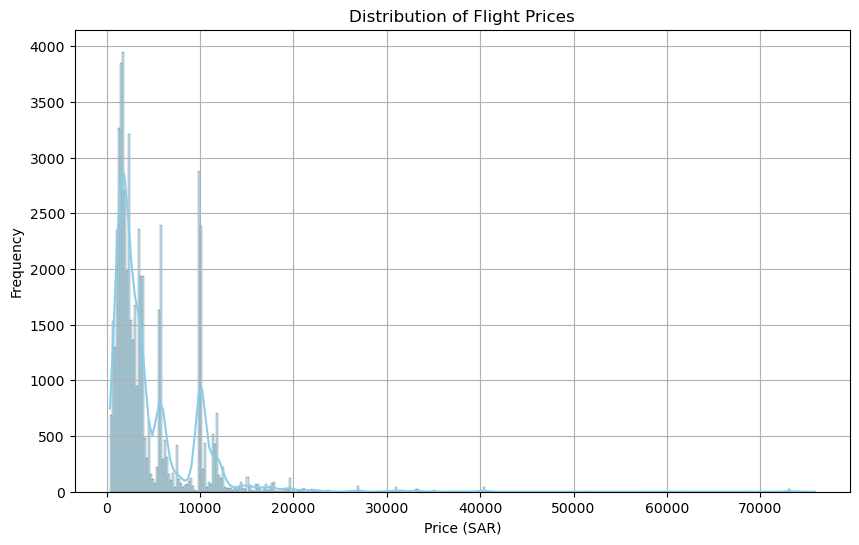

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, color='skyblue')
plt.title('Distribution of Flight Prices')
plt.xlabel('Price (SAR)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

✅ 1. Price Distribution <br>
* Insight: Tells you whether flight prices are normally distributed or skewed.
* Often right-skewed (most tickets are cheap, a few are very expensive).
* Helps you decide whether to log-transform prices for modeling.

* ### B. How Airline Affects Price — Boxplot

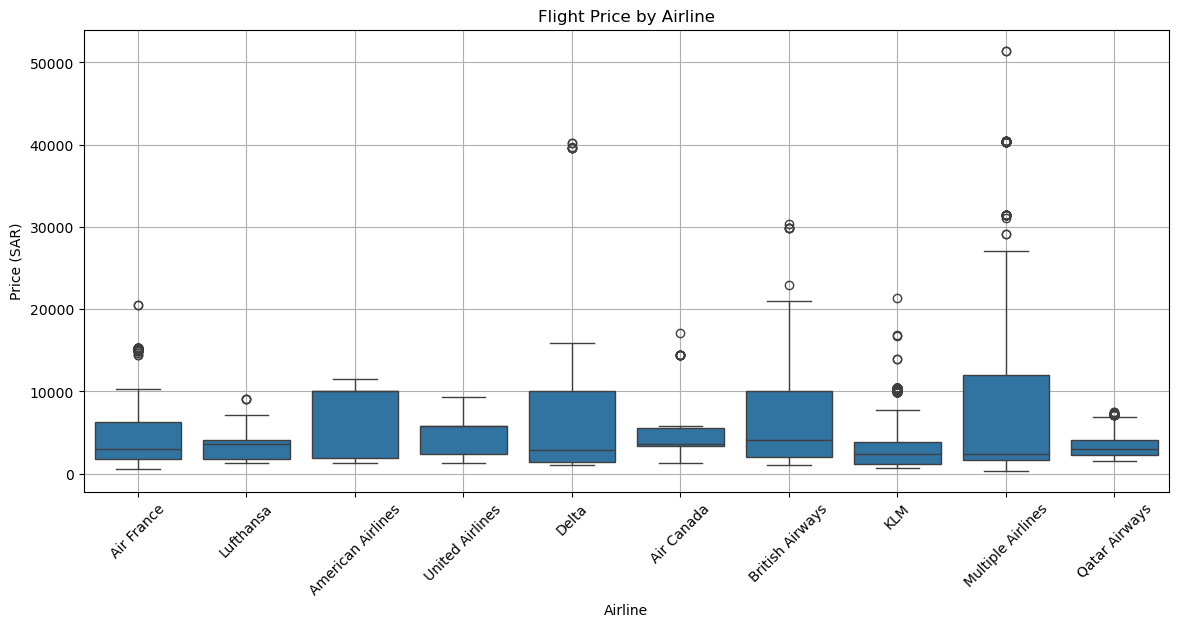

In [22]:
plt.figure(figsize=(14, 6))
top_airlines = df['Airline'].value_counts().head(10).index  # Focus on most frequent airlines
sns.boxplot(data=df[df['Airline'].isin(top_airlines)], x='Airline', y='Price')
plt.xticks(rotation=45)
plt.title('Flight Price by Airline')
plt.ylabel('Price (SAR)')
plt.grid(True)
plt.show()

✅ 2. Airline vs Price (Boxplot)<br>
* Insight: Compares how different airlines price their tickets.
* Wide boxes → higher price variability.
* Outliers → extreme pricing.
* High median → generally expensive airline.

* ### C. Duration vs Price — Scatter Plot

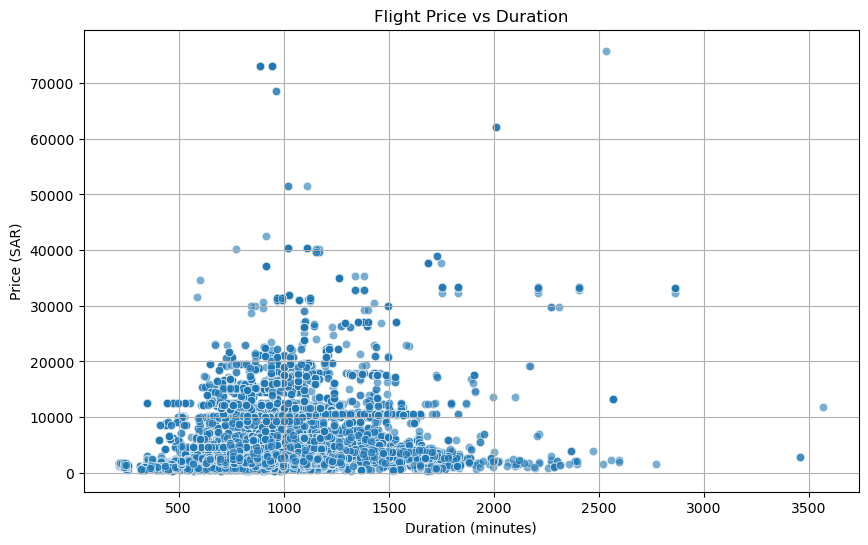

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Duration', y='Price', alpha=0.6)
plt.title('Flight Price vs Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Price (SAR)')
plt.grid(True)
plt.savefig('Distribution of Flight Duration and Price.png')
plt.show()

✅ 3. Duration vs Price (Scatter)
* Insight: Checks if longer durations mean cheaper flights (common with layovers).
* Upward trend → longer flights = costlier.
* Downward trend → longer flights = cheaper (layover/low-cost carriers).
* Cloud shape → noisy relationship.

---
## <center>Model Preparation & Training

* ### A: Prepare Features & Target

In [24]:
# Features we'll use for modeling
features = ['Airline_encoded', 'Source_encoded', 'Duration', 'Duration_squared', 'Total stops']
X = df[features]
y = df['Price']

In [25]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* ### B: Train a Simple Linear Regression

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
y_pred = lr.predict(X_test)

In [28]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

C:\Users\PARAM\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
print(f"Linear Regression Performance:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.4f}")

Linear Regression Performance:
MAE  = 2007.31
RMSE = 3448.34
R²   = 0.4561


🔍 Interpreting Your Results<br>
* MAE	    (~2007 SAR)->	   On average, predictions are off by ₹2000
* RMSE	    (~3448 SAR)->	   Higher penalties for large errors
* R²	      (0.4561)->	   ~46% of the price variation is explained by your features

💡 Conclusion:<br>
* This model captures basic trends, but there's still 54% variance unexplained.
* That’s expected — linear models can’t capture complex patterns or interactions.

* ### XGBoost Model Training

In [30]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [31]:
y_pred_xgb = xgb.predict(X_test)

In [32]:
# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

C:\Users\PARAM\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
print(f"XGBoost Performance:")
print(f"MAE  = {mae_xgb:.2f}")
print(f"RMSE = {rmse_xgb:.2f}")
print(f"R²   = {r2_xgb:.4f}")

XGBoost Performance:
MAE  = 941.21
RMSE = 2010.53
R²   = 0.8151


In [34]:
joblib.dump(xgb, '../model/xgb_model.pkl')

['../model/xgb_model.pkl']

C:\Users\PARAM\AppData\Local\Temp\ipykernel_1928\1482027825.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')


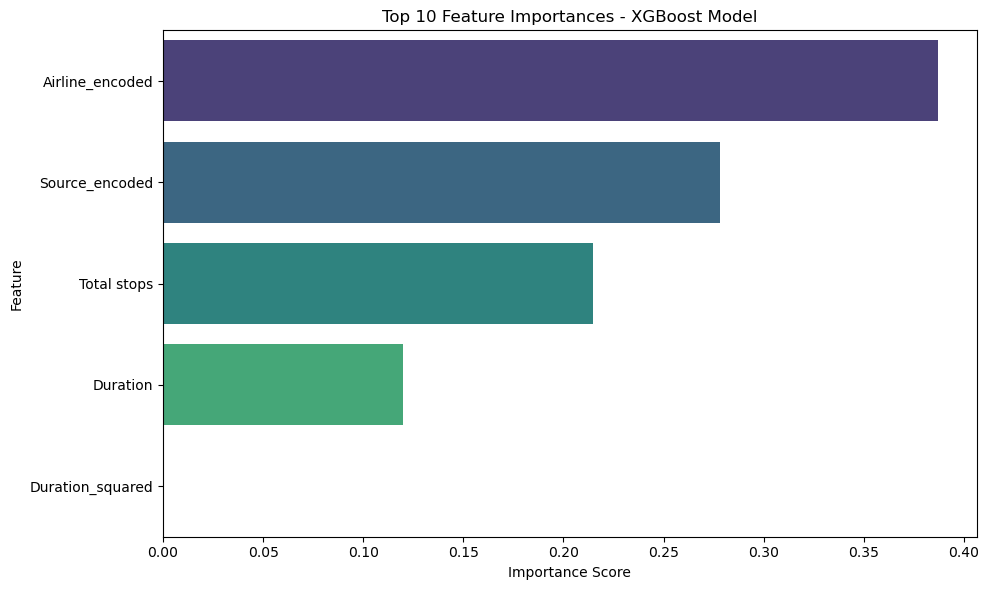

In [36]:
importances = xgb.feature_importances_
feature_names = X_train.columns  # Replace X_train with your actual training DataFrame

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances - XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


C:\Users\PARAM\AppData\Local\Temp\ipykernel_1928\2127960797.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(20), x='Coefficient', y='Feature', palette='coolwarm')


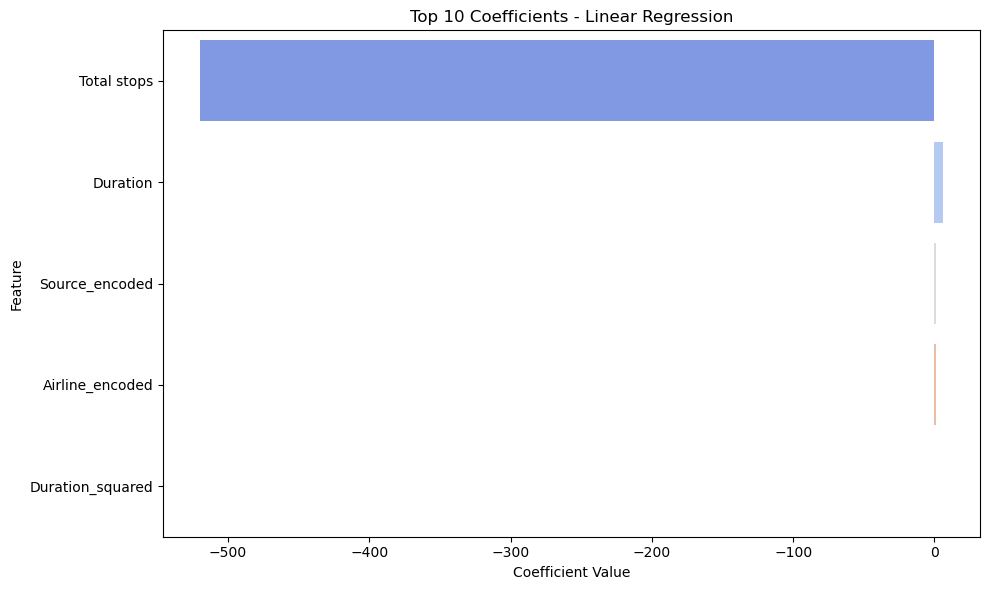

In [41]:
coefs = lr.coef_
feature_names = X_train.columns  # Replace with your feature DataFrame

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(20), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 10 Coefficients - Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()